In [1]:
import torch

from data.dataset import REFLACXWithClinicalDataset
from model.xami import XAMIMultiModalSum, XAMIMultiCocatModal
from utils.train import split_dataset, train_with_auc_margin_loss

In [2]:
# ## Reproducibility
seed = 234
# torch.use_deterministic_algorithms(True)
# torch.manual_seed(seed)
# random.seed(seed)
# np.random.seed(seed)

In [3]:
# checking if the GPU is available
use_gpu = torch.cuda.is_available()

# setting up the device
device = 'cuda' if use_gpu else 'cpu'

print(f"Will be using {device}")

Will be using cuda


In [4]:
# load the dataset
reflacx_dataset = REFLACXWithClinicalDataset(image_size=256)

# keep the architecture simple, so we check the image nn first.
# prepare the model
xami_mutlimodal = XAMIMultiCocatModal(
    reflacx_dataset,
    device,
    use_clinical=True,
    model_dim=32, # was 64
    embeding_dim=64,
    dropout=.2,  # increase tClihe dropout rate did improve the regularization. # from .3
    pretrained=True,
    detach_image=True,
    use_image=False,
)

xami_mutlimodal = xami_mutlimodal.to(device)

Positive Loss weight:
[0.768546   0.78635013 0.7937685  0.8338279  0.87388724]
Negative Loss weight:
[0.231454   0.21364985 0.20623146 0.1661721  0.12611276]
Random Loss:
0.21026036153991162


In [11]:
reflacx_dataset.encoders_map['gender'].classes_

array(['F', 'M'], dtype=object)

In [5]:
### loading our pretrained model.

# without_clinical_model = 'test_0_8162_epoch300_WithoutClincal_dim32_2022-02-07 21_43_31_353207 '

# all_weights = torch.load(os.path.join('saved_models', without_clinical_model ), map_location=device)

# all_k = list(all_weights.keys())

# for k in all_k:
#     if not 'image_net' in k:
#         all_weights.pop(k)

# xami_mutlimodal.load_state_dict(all_weights, strict=False)

# # xami_mutlimodal.load_state_dict(torch.load(os.path.join('saved_models', without_clinical_model ), map_location=device), strict=False)

# xami_mutlimodal = xami_mutlimodal.to(device)

In [6]:
xami_mutlimodal.num_all_params()

22245

In [7]:
batch_size = 64

dataloaders = split_dataset(
    reflacx_dataset,
    batch_size,
    traing_portion=.7,
    test_portion=.15,
    seed=seed #changed
)

In [8]:
# lr = 1e-2

# optimizer = optim.Adam(
#     xami_mutlimodal.parameters(),
#     lr=lr,
#     weight_decay=1e-6
# )

# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
#                                                  patience=10,
#                                                  threshold=1e-3,
#                                                  factor=0.5
#                                                  )

## scheduler = None


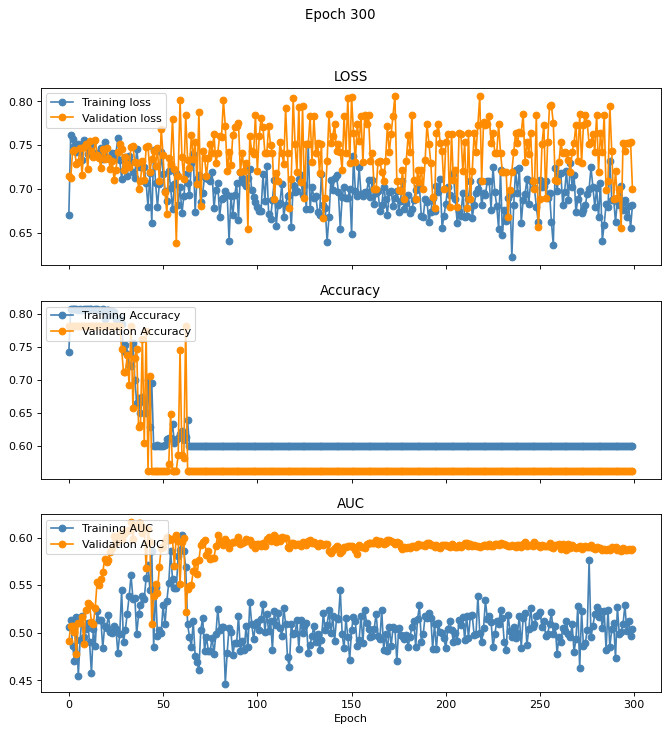


====================Current Learning Rate====================
| 0.0008 

====================Training Result====================
| LOSS 0.6819 | ACC 0.6000 | AUC  0.5037 

| Training Confusion Matrix 

| Enlarged cardiac silhouette 
              Pred_False  Pred_True
Target_False           0        354
Target_True            0        117

| Atelectasis 
              Pred_False  Pred_True
Target_False           0        361
Target_True            0        110

| Pleural abnormality 
              Pred_False  Pred_True
Target_False         375          0
Target_True           96          0

| Consolidation 
              Pred_False  Pred_True
Target_False         395          0
Target_True           76          0

| Pulmonary edema 
              Pred_False  Pred_True
Target_False         416          0
Target_True           55          0

====================Validation Result====================
| LOSS 0.6996 | ACC 0.5627 | AUC  0.5880 

| Validation Confusion Matrix 

| Enlarged car

In [11]:
# With clinical
train_data_1, val_data_1, test_data_1, model_names = train_with_auc_margin_loss(
    num_epochs=300,
    model=xami_mutlimodal,
    dataloaders=dataloaders,
    dataset=reflacx_dataset,
    device=device,
    lr=1e-1,
    # scheduler_freq=None,
)


# detach first. # then train

In [12]:
# wieght chekcing.
# xami_mutlimodal.image_net.model_ft.features.conv0.weight.grad.sum()